In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from scipy.stats import uniform, randint

In [2]:
# lodind csv file into dataframe
df = pd.read_csv("FakeNewsNet.csv")

df.head()

,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [3]:
# lower case all text
df.columns = df.columns.str.lower().str.strip()
df['title'] = df['title'].str.lower()
df['source_domain'] = df['source_domain'].str.lower()

# removing whitespaces
df['title'] = df['title'].str.strip()
df['source_domain'] = df['source_domain'].str.strip()

# removing special characters from title
df['title'] = df['title'].str.replace(r'[^\w\s]', '', regex=True)
df.head()

,title,news_url,source_domain,tweet_num,real
0,kandi burruss explodes over rape accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,peoples choice awards 2018 the best red carpet...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,colombian singer maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,gossip girl 10 years later how upper east side...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
tweet_num,23196.0,88.956803,488.694592,0.0,11.0,37.0,65.0,29060.0
real,23196.0,0.751897,0.431921,0.0,1.0,1.0,1.0,1.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23196 entries, 0 to 23195
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          23196 non-null  object
 1   news_url       22866 non-null  object
 2   source_domain  22866 non-null  object
 3   tweet_num      23196 non-null  int64 
 4   real           23196 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 906.2+ KB


In [6]:
# keeping record of prior state
df_info_before = {"shape_before" : df.shape,
                  "duplicates_before" : df.duplicated().sum(),
                  "null_values_before" : df.isnull().sum().to_dict()
                 }

df_info_before

{'shape_before': (23196, 5),
 'duplicates_before': 137,
 'null_values_before': {'title': 0,
  'news_url': 330,
  'source_domain': 330,
  'tweet_num': 0,
  'real': 0}}

## Handling Duplicate Value

In [7]:
df_info_before["shape_before"][0]

23196

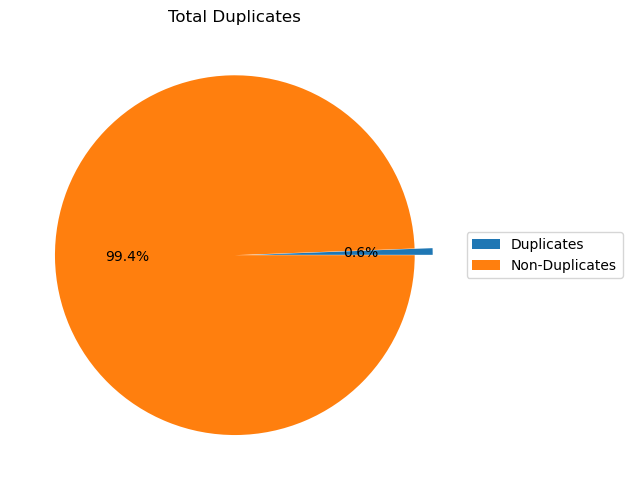

In [8]:
plt.figure(figsize=(5,5))

total_rows = df_info_before["shape_before"][0]
duplicates = df_info_before["duplicates_before"]

# taking count of duplicate and non-duplicate values
divisions = np.array([duplicates , total_rows - duplicates])
labels=["Duplicates", "Non-Duplicates"]

plt.pie(divisions, autopct='%1.1f%%', explode = [0.1,0])
plt.title("Total Duplicates")
plt.tight_layout()
plt.legend(labels, loc="center left", bbox_to_anchor=(1,0.5))
plt.show()

In [9]:
# creating a copy of df which can be modified without chaning the actual df
df_cleaned = df.copy()

df_cleaned = df_cleaned.drop_duplicates()

df_cleaned.duplicated().sum()

0

## Handling Null values

C:\Users\saket\AppData\Local\Temp\ipykernel_2412\3245957940.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=null_value_count.index,


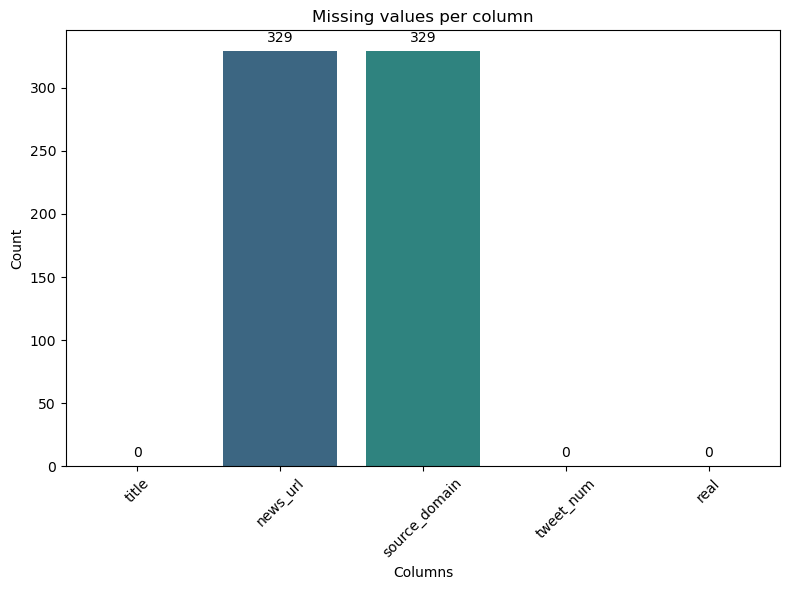

In [10]:
null_value_count = df_cleaned.isnull().sum()

plt.figure(figsize = (8,6))
sns.barplot(x=null_value_count.index,
            y=null_value_count.values,
            palette="viridis"
           )

for i , value in enumerate(null_value_count.values):
    plt.text(i, value + 5, 
             str(value), ha='center', 
             va='bottom', fontsize=10
            )
    
plt.xticks(rotation=45)
plt.title("Missing values per column")
plt.xlabel("Columns")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [11]:
# filling null position with 'unknown' because URL and domains can not be random
df_cleaned["news_url"] = df_cleaned["news_url"].fillna("unknown")
df_cleaned["source_domain"] = df_cleaned["source_domain"].fillna("unknown")

In [12]:
df_cleaned = df_cleaned.reset_index(drop=True)

df_info_after = {"shape_after" : df_cleaned.shape,
                 "duplicates_after" : df_cleaned.duplicated().sum(),
                 "null_values_after" : df_cleaned.isnull().sum().to_dict()
                }

# comparing with the prior record
df_info_before, df_info_after

({'shape_before': (23196, 5),
  'duplicates_before': 137,
  'null_values_before': {'title': 0,
   'news_url': 330,
   'source_domain': 330,
   'tweet_num': 0,
   'real': 0}},
 {'shape_after': (23059, 5),
  'duplicates_after': 0,
  'null_values_after': {'title': 0,
   'news_url': 0,
   'source_domain': 0,
   'tweet_num': 0,
   'real': 0}})

## Encoding source_domain

In [13]:
len(df_cleaned["source_domain"].unique())

2442

In [14]:
le = LabelEncoder()

# serializing all the domains which may make then find easily
df_cleaned["source_domain_encoded"] = le.fit_transform(df_cleaned["source_domain"])

df_cleaned.head()

,title,news_url,source_domain,tweet_num,real,source_domain_encoded
0,kandi burruss explodes over rape accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,972
1,peoples choice awards 2018 the best red carpet...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1,2260
2,sophia bush sends sweet birthday message to on...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1,1436
3,colombian singer maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1,1355
4,gossip girl 10 years later how upper east side...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1,2420


# EDA

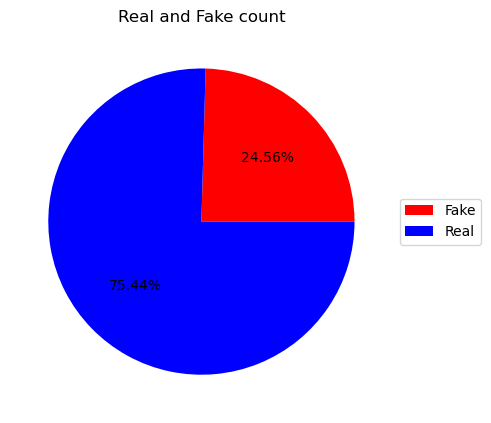

In [15]:
real_fake_count = df_cleaned["real"].value_counts().sort_index()
real_fake_labels = ["Fake", "Real"]

plt.figure(figsize=(5,5))

plt.pie(real_fake_count, 
        autopct='%1.2f%%',
        colors=["red", "blue"]
       )

plt.title("Real and Fake count")
plt.legend(labels=real_fake_labels, loc="center left", bbox_to_anchor=(1,0.5))
plt.tight_layout()
plt.show()



<Figure size 1000x1000 with 0 Axes>

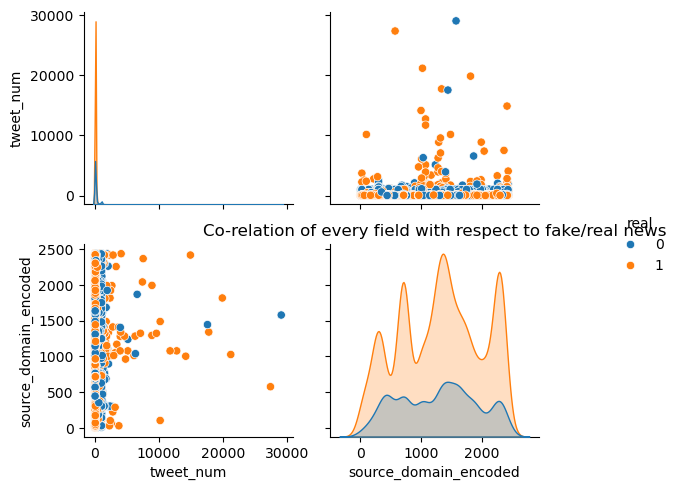

In [16]:
plt.figure(figsize=(10,10))
sns.pairplot(data=df_cleaned, hue="real")
plt.title("Co-relation of every field with respect to fake/real news")
plt.tight_layout()
plt.show()

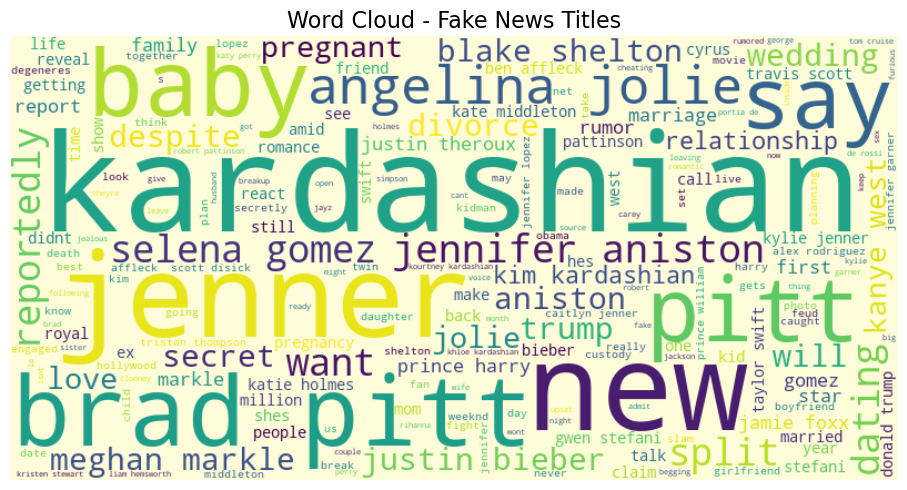

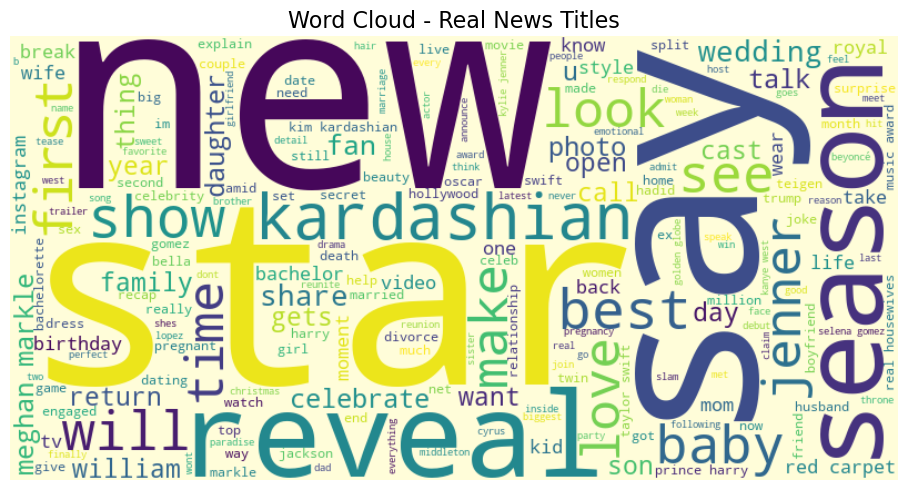

In [17]:
df_fake = df[df["real"] == 0]
df_real = df[df["real"] == 1]

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, 
                          height=400, 
                          background_color="#FFFDD9"
                         ).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, 
               interpolation="bilinear"
              )
    plt.axis('off')
    plt.title(title,fontsize=16)
    plt.tight_layout()
    plt.show()

generate_wordcloud("".join(df_fake["title"]), "Word Cloud - Fake News Titles")
generate_wordcloud("".join(df_real["title"]), "Word Cloud - Real News Titles")

In [18]:
# domains sharing both fake and real news
source_domain_real = df_cleaned["source_domain"][df["real"] == 1].unique()
source_domain_fake = df_cleaned["source_domain"][df["real"] == 0].unique()

common_source_domain = np.intersect1d(source_domain_real, source_domain_fake)
len(common_source_domain)

691

### Based on Domains

<Figure size 600x2000 with 0 Axes>

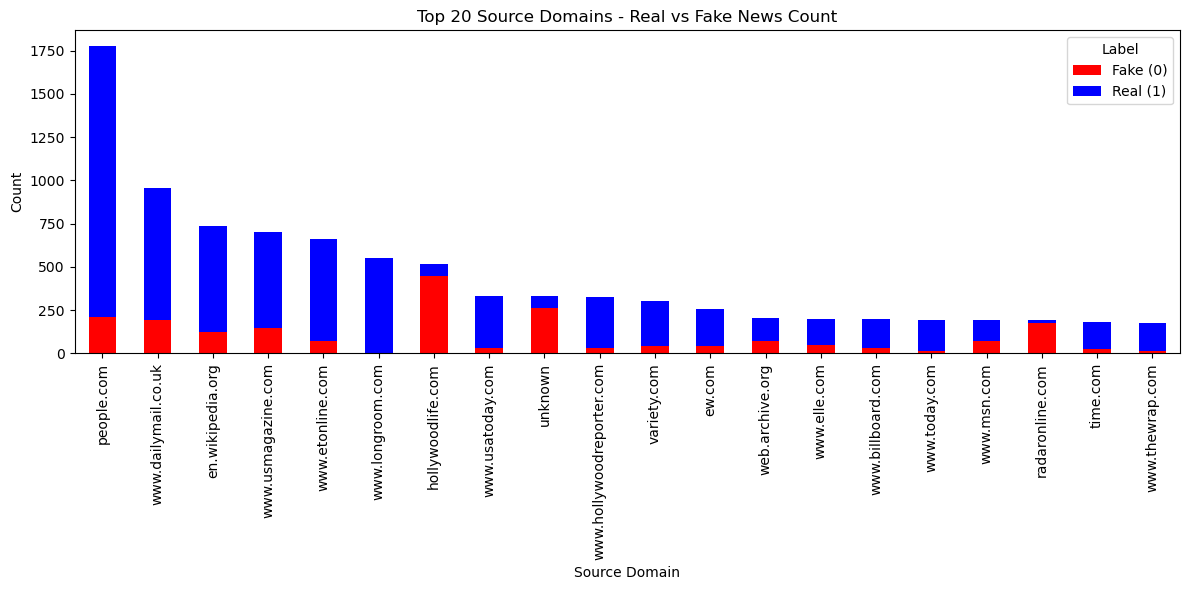

<Figure size 600x2000 with 0 Axes>

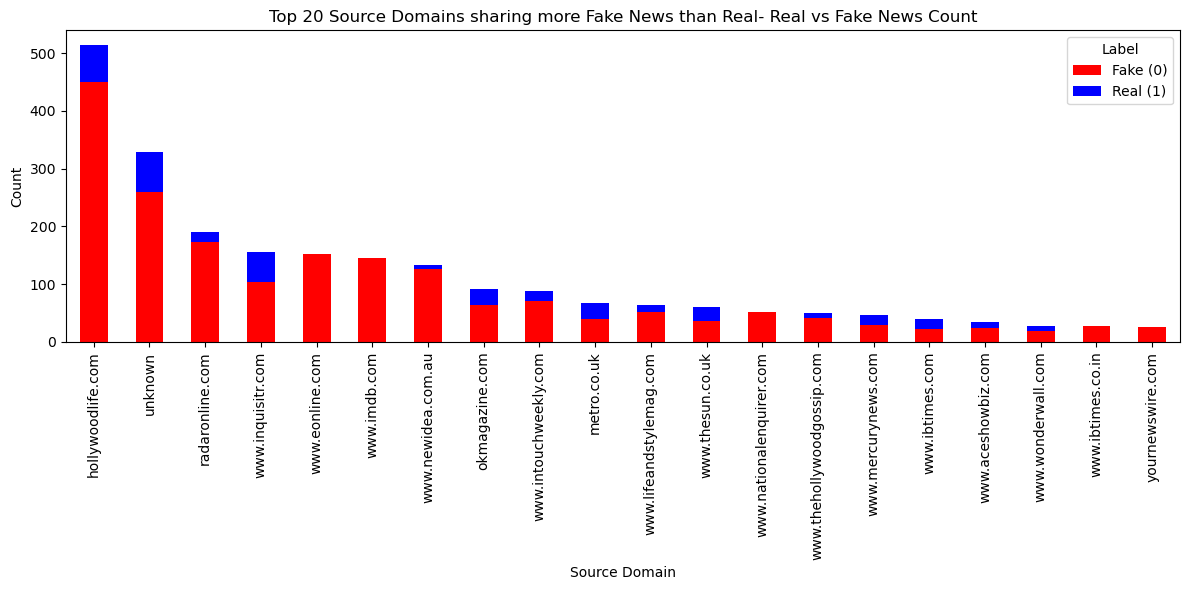

<Figure size 600x2000 with 0 Axes>

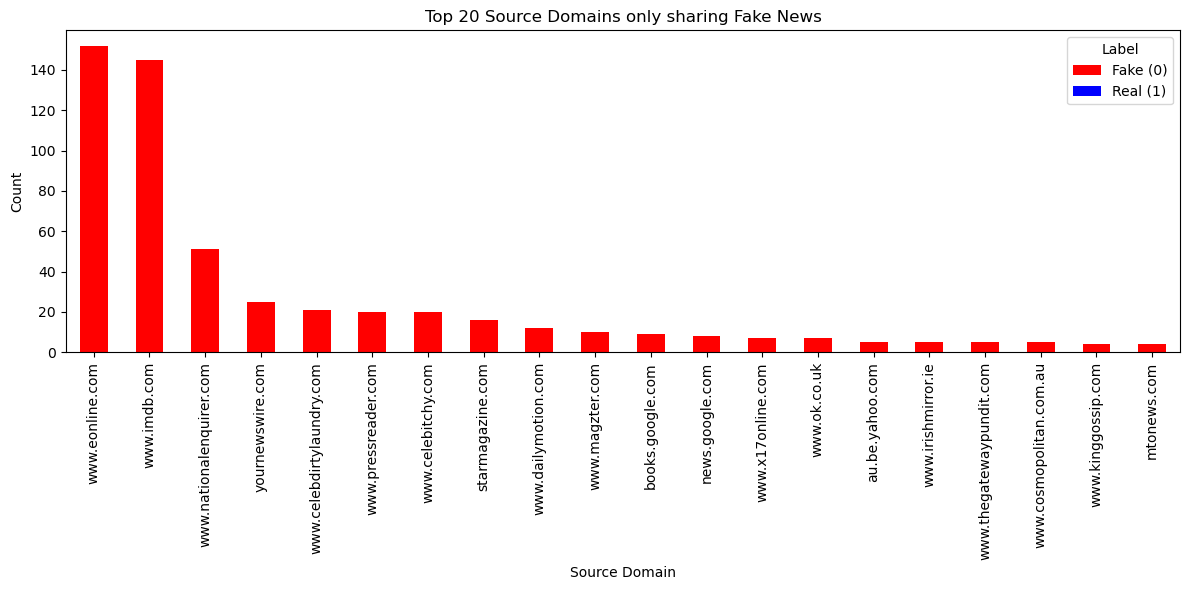

<Figure size 600x2000 with 0 Axes>

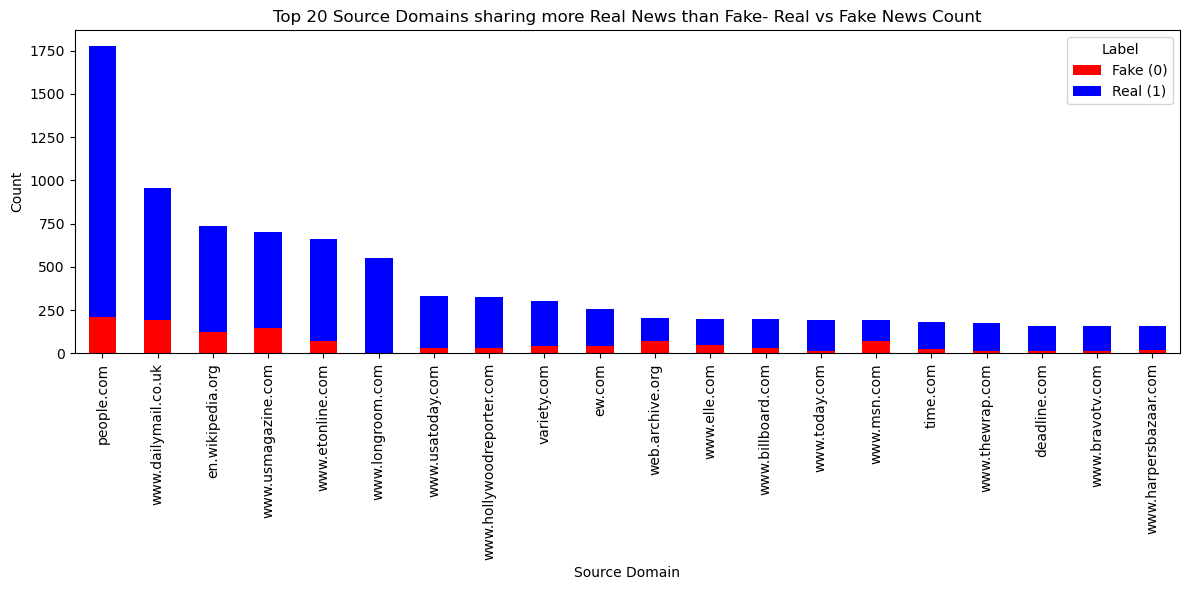

<Figure size 600x2000 with 0 Axes>

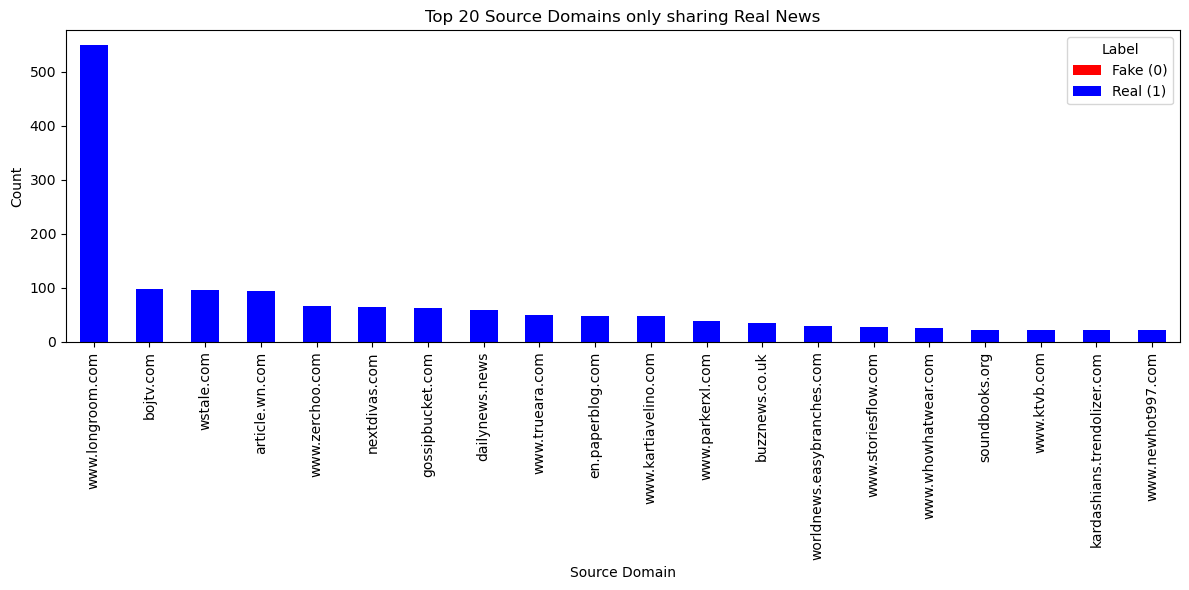

In [29]:
# extracting the number of real and fake news all the domains share
source_domain_fake_real_count = (df_cleaned.groupby(["source_domain", "real"])
                                 .size()
                                 .unstack(fill_value=0)
                                )

# top 20 most active domains
top_20_domains = source_domain_fake_real_count.sum(axis=1).sort_values(ascending=False).head(20)
top_20_pivot = source_domain_fake_real_count.loc[top_20_domains.index]

plt.figure(figsize=(6,20))
top_20_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )
plt.title("Top 20 Source Domains - Real vs Fake News Count")
plt.xlabel("Source Domain")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# domains sharing more fake news than real
unreliable_sources = source_domain_fake_real_count[source_domain_fake_real_count[0] > source_domain_fake_real_count[1]]

# top 20 domains share more fake news then real
top_20_unreliable_sources = unreliable_sources.sum(axis=1).sort_values(ascending=False).head(20)

top_20_unreliable_pivot = unreliable_sources.loc[top_20_unreliable_sources.index]

plt.figure(figsize=(6,20))
top_20_unreliable_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Source Domains sharing more Fake News than Real- Real vs Fake News Count")
plt.xlabel("Source Domain")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# domains sharing only fake news
fake_sources = source_domain_fake_real_count[source_domain_fake_real_count[1] == 0]

# top 20 domains share only fake news
top_20_fake_sources = fake_sources.sum(axis=1).sort_values(ascending=False).head(20)

top_20_fake_pivot = fake_sources.loc[top_20_fake_sources.index]

plt.figure(figsize=(6,20))
top_20_fake_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Source Domains only sharing Fake News")
plt.xlabel("Source Domain")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# domains sharing more real news than fake
reliable_sources = source_domain_fake_real_count[source_domain_fake_real_count[1] > source_domain_fake_real_count[0]]

# top 20 domains share more real news then fake
top_20_reliable_sources = reliable_sources.sum(axis=1).sort_values(ascending=False).head(20)

top_20_reliable_pivot = reliable_sources.loc[top_20_reliable_sources.index]

plt.figure(figsize=(6,20))
top_20_reliable_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Source Domains sharing more Real News than Fake- Real vs Fake News Count")
plt.xlabel("Source Domain")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# domains sharing only real news
real_sources = source_domain_fake_real_count[source_domain_fake_real_count[0] == 0]

# top 20 domains share only real news
top_20_real_sources = real_sources.sum(axis=1).sort_values(ascending=False).head(20)

top_20_real_pivot = real_sources.loc[top_20_real_sources.index]

plt.figure(figsize=(6,20))
top_20_real_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Source Domains only sharing Real News")
plt.xlabel("Source Domain")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

### Based on Tweets

<Figure size 600x2000 with 0 Axes>

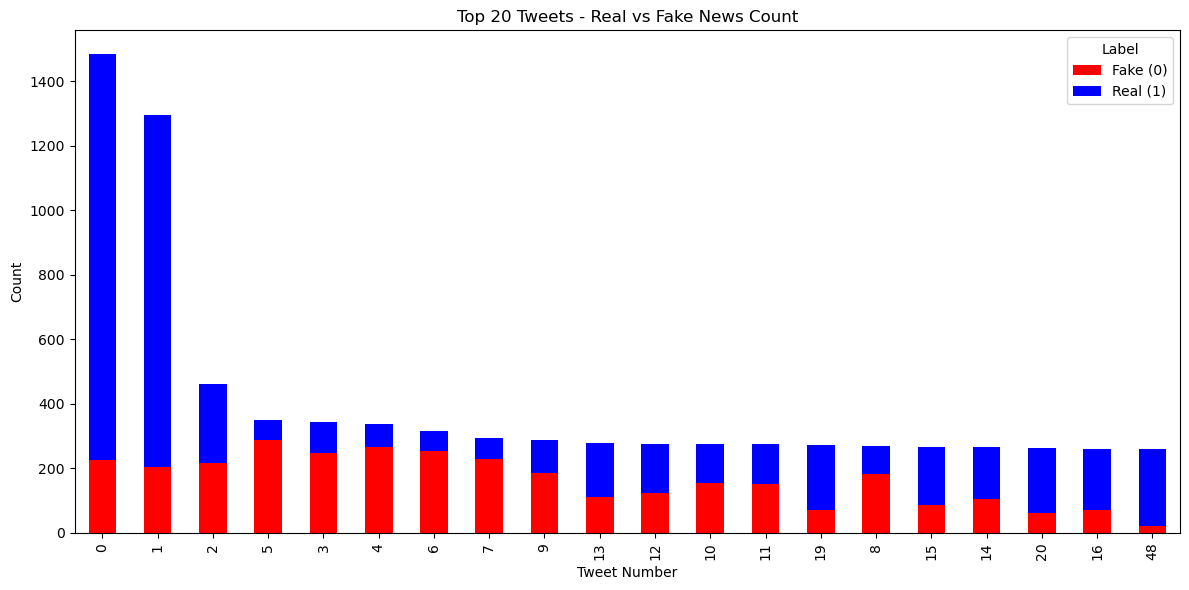

<Figure size 600x2000 with 0 Axes>

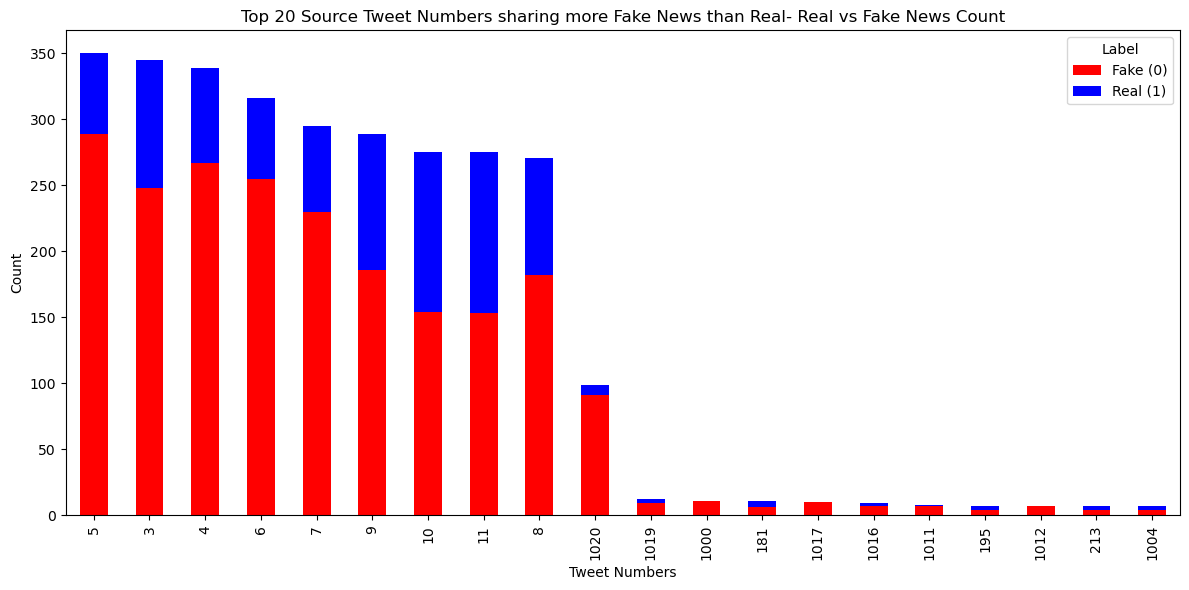

<Figure size 600x2000 with 0 Axes>

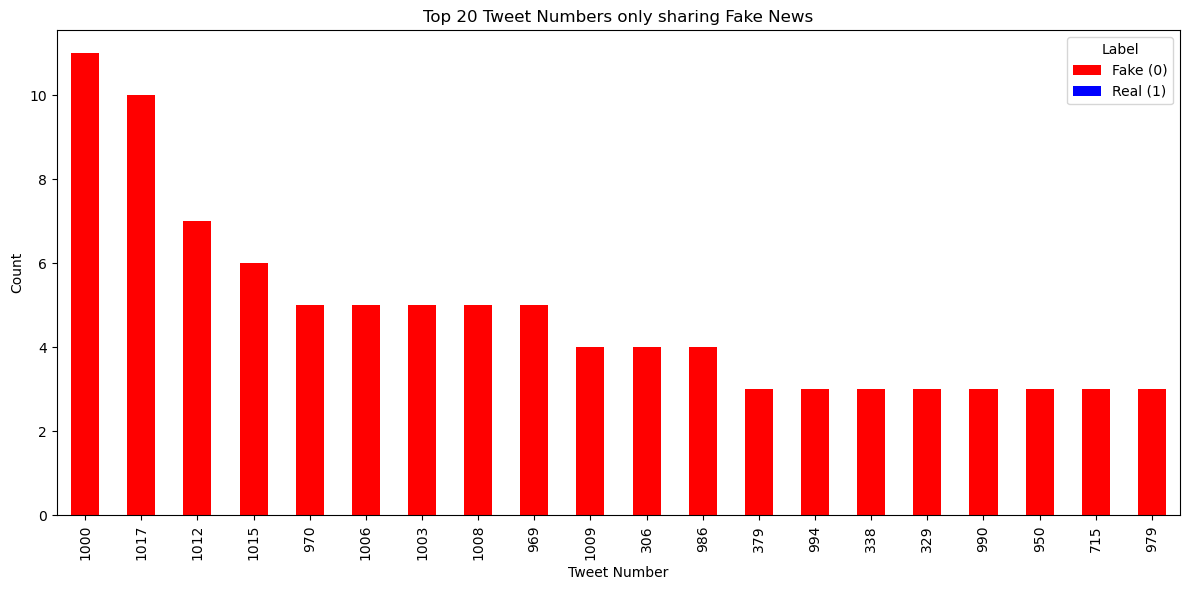

<Figure size 600x2000 with 0 Axes>

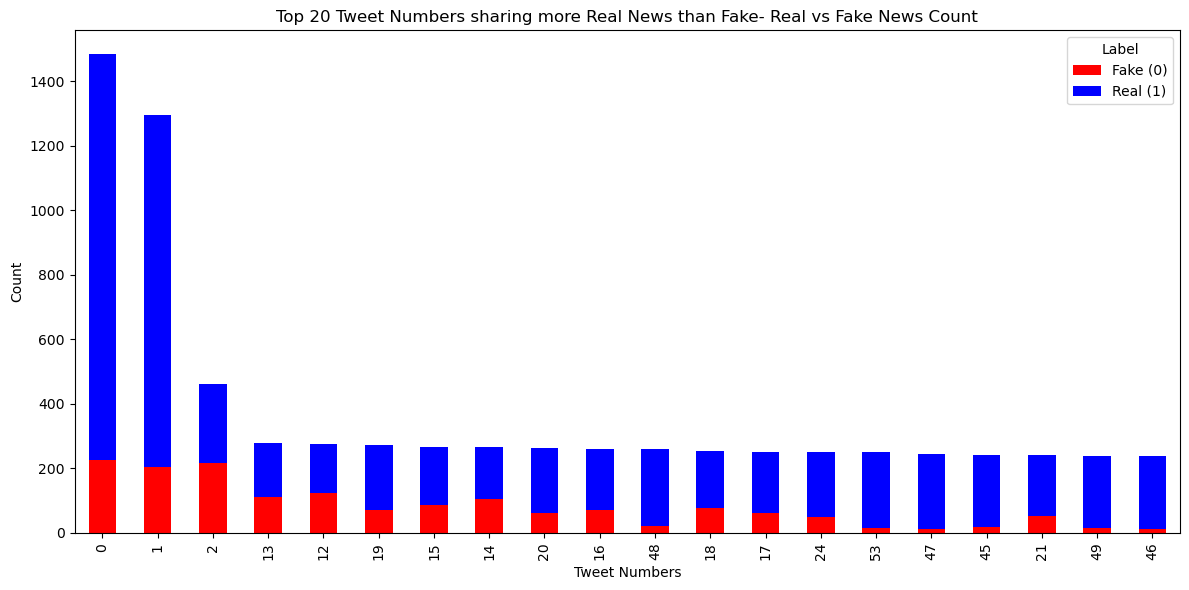

<Figure size 600x2000 with 0 Axes>

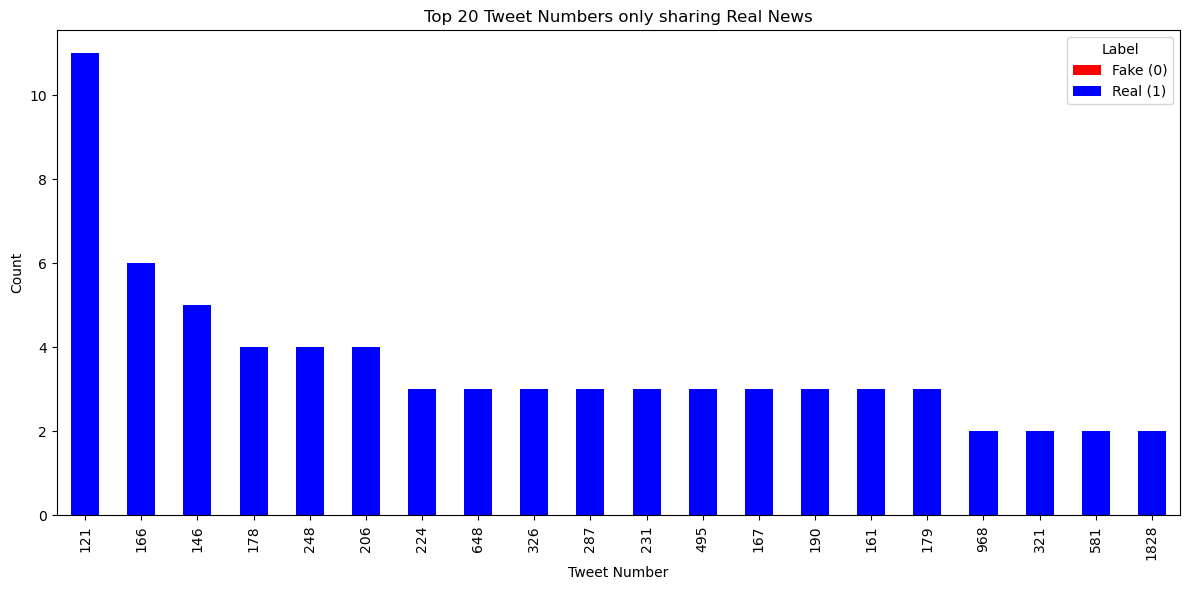

In [28]:
# extracting the most amount of tweets
tweets_fake_real_count = (df_cleaned.groupby(["tweet_num", "real"])
                                 .size()
                                 .unstack(fill_value=0)
                                )

# top 20 tweet numbers
top_20_tweet_numbers = tweets_fake_real_count.sum(axis=1).sort_values(ascending=False).head(20)
top_20_pivot = tweets_fake_real_count.loc[top_20_tweet_numbers.index]

plt.figure(figsize=(6,20))
top_20_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Tweets - Real vs Fake News Count")
plt.xlabel("Tweet Number")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# tweet numbers sharing more fake news than real
unreliable_tweet_numbers = tweets_fake_real_count[tweets_fake_real_count[0] > tweets_fake_real_count[1]]

# top 20 tewwt number share more fake news then real
top_20_unreliable_tweet_numbers = unreliable_tweet_numbers.sum(axis=1).sort_values(ascending=False).head(20)

top_20_unreliable_tweet_pivot = unreliable_tweet_numbers.loc[top_20_unreliable_tweet_numbers.index]

plt.figure(figsize=(6,20))
top_20_unreliable_tweet_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Source Tweet Numbers sharing more Fake News than Real- Real vs Fake News Count")
plt.xlabel("Tweet Numbers")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# tweet number sharing only fake news
fake_tweet_numbers = tweets_fake_real_count[tweets_fake_real_count[1] == 0]

# top 20 tweet number share only fake news
top_20_fake_tweet_numbers = fake_tweet_numbers.sum(axis=1).sort_values(ascending=False).head(20)

top_20_fake_tweet_pivot = fake_tweet_numbers.loc[top_20_fake_tweet_numbers.index]

plt.figure(figsize=(6,20))
top_20_fake_tweet_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Tweet Numbers only sharing Fake News")
plt.xlabel("Tweet Number")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# tweet numbers sharing more real news than fake
reliable_tweet_numbers = tweets_fake_real_count[tweets_fake_real_count[1] > tweets_fake_real_count[0]]

# top 20 tewwt number share more real news then fake
top_20_reliable_tweet_numbers = reliable_tweet_numbers.sum(axis=1).sort_values(ascending=False).head(20)

top_20_reliable_tweet_pivot = reliable_tweet_numbers.loc[top_20_reliable_tweet_numbers.index]

plt.figure(figsize=(6,20))
top_20_reliable_tweet_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Tweet Numbers sharing more Real News than Fake- Real vs Fake News Count")
plt.xlabel("Tweet Numbers")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

# tweet number sharing only real news
real_tweet_numbers = tweets_fake_real_count[tweets_fake_real_count[0] == 0]

# top 20 tweet number share only real news
top_20_real_tweet_numbers = real_tweet_numbers.sum(axis=1).sort_values(ascending=False).head(20)

top_20_real_tweet_pivot = real_tweet_numbers.loc[top_20_real_tweet_numbers.index]

plt.figure(figsize=(6,20))
top_20_real_tweet_pivot.plot(kind="bar",
                  stacked=True,
                  figsize=(12,6),
                  color={0:"red", 1:"blue"}
                 )

plt.title("Top 20 Tweet Numbers only sharing Real News")
plt.xlabel("Tweet Number")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(["Fake (0)", "Real (1)"], title="Label")
plt.tight_layout()
plt.show()

## Feature Engineering

In [21]:
# getting size of each title
df_cleaned["title_length"] = df_cleaned["title"].apply(len)

# word count of each title
df_cleaned["title_word_count"] = df_cleaned["title"].apply(lambda x: len(x.split()))

# segrigating popular and unpopular domains
df_cleaned["is_popular_source"] = df_cleaned["source_domain"].apply(lambda x: 1 if x in top_20_domains else 0)

# tweet per words
df_cleaned["tweet_per_words"] = df_cleaned["tweet_num"] / (df_cleaned["title_word_count"] + 1e-5)  # a very small number is added to avoid division by 0

df_cleaned.head(1)

,title,news_url,source_domain,tweet_num,real,source_domain_encoded,title_length,title_word_count,is_popular_source,tweet_per_words
0,kandi burruss explodes over rape accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1,972,87,13,0,3.230767


## Model Traning

1. Logistic Regression
2. Moltinomial Naive Bayes
3. Linear Support Vector Machine
4. Random Forest
5. LightGBM

In [22]:
# creating a function to represent results of all model
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,
                annot=True,
                fmt='d',
                cmap="cividis",
                xticklabels=["Fake","Real"],
                yticklabels=["Fake","Real"]
               )
   
    plt.title(f"Confusion Matrix = {model_name}", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("Actual Label", fontsize=12)
    plt.show()

In [23]:
X = df_cleaned["title"]
y = df_cleaned["real"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


--- Training and Tuning Logistic Regression ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Logistic Regression: 
{'classifier__C': 4.660699842170359, 'classifier__solver': 'liblinear'}

Accuracy for Logistic Regression: 0.8476

ROC AUC for Logistic Regression: 0.8706

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.76      0.56      0.64      1140
        Real       0.87      0.94      0.90      3472

    accuracy                           0.85      4612
   macro avg       0.81      0.75      0.77      4612
weighted avg       0.84      0.85      0.84      4612



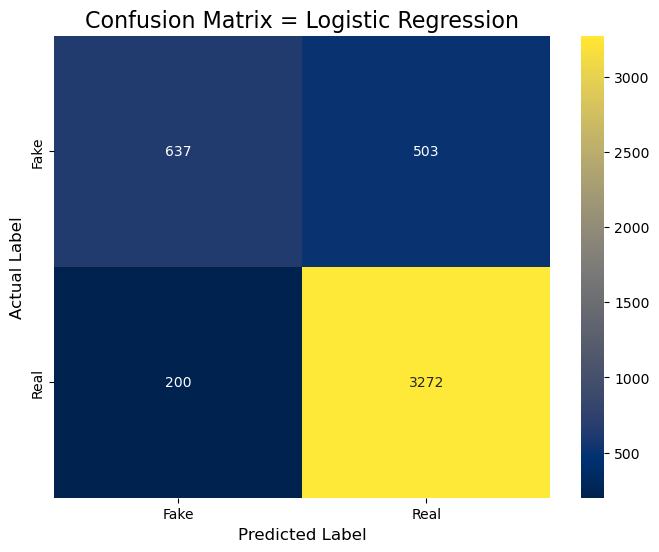


--- Training and Tuning Multinomial Naive Bayes ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Multinomial Naive Bayes: 
{'classifier__alpha': 0.19340450985343383}

Accuracy for Multinomial Naive Bayes: 0.8387

ROC AUC for Multinomial Naive Bayes: 0.8693

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.77      0.50      0.60      1140
        Real       0.85      0.95      0.90      3472

    accuracy                           0.84      4612
   macro avg       0.81      0.72      0.75      4612
weighted avg       0.83      0.84      0.83      4612



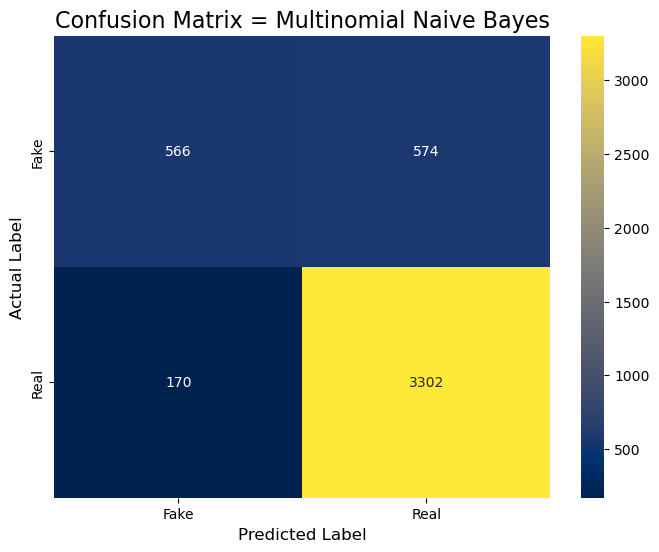


--- Training and Tuning Linear SVM ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Linear SVM: 
{'classifier__C': 0.30584494295802445}

Accuracy for Linear SVM: 0.8506

ROC AUC for Linear SVM: 0.8715

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.79      0.54      0.64      1140
        Real       0.86      0.95      0.91      3472

    accuracy                           0.85      4612
   macro avg       0.83      0.75      0.77      4612
weighted avg       0.84      0.85      0.84      4612



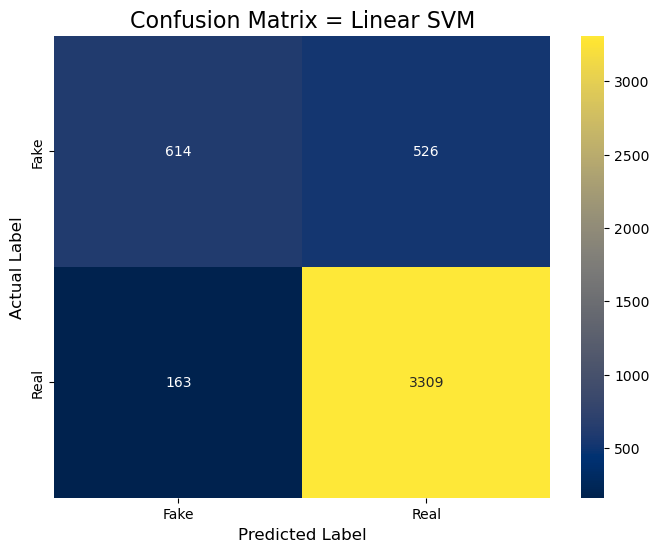


--- Training and Tuning Random Forest ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters for Random Forest: 
{'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 230}

Accuracy for Random Forest: 0.7791

ROC AUC for Random Forest: 0.8406

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.88      0.12      0.22      1140
        Real       0.78      0.99      0.87      3472

    accuracy                           0.78      4612
   macro avg       0.83      0.56      0.54      4612
weighted avg       0.80      0.78      0.71      4612



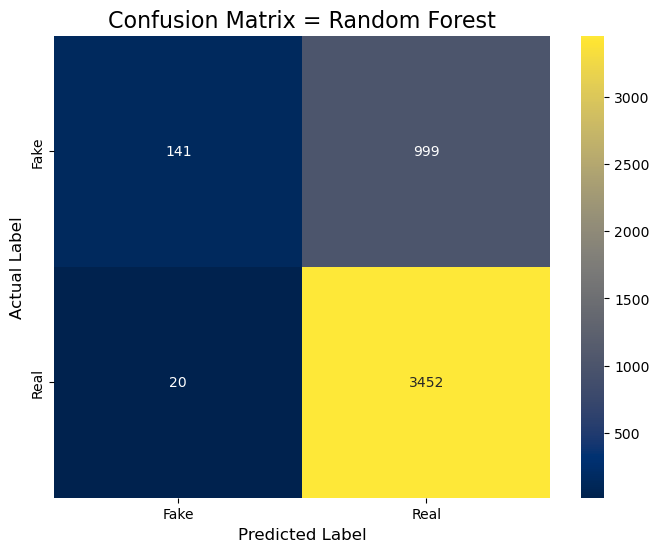


--- Training and Tuning LightGBM ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 13924, number of negative: 4523
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.143107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31545
[LightGBM] [Info] Number of data points in the train set: 18447, number of used features: 1418
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.754811 -> initscore=1.124438
[LightGBM] [Info] Start training from score 1.124438

Best parameters for LightGBM: 
{'classifier__learning_rate': 0.04410482473745831, 'classifier__n_estimators': 266, 'classifier__num_leaves': 37}

Accuracy for LightGBM: 0.8363

ROC AUC for LightGBM: 0.8483

Classification Report: 
              precision    recall  f1-score   support

        Fake       0.76      0.50      0.60      1140
        Real       0.85      0.95      0.90      3472

    accurac

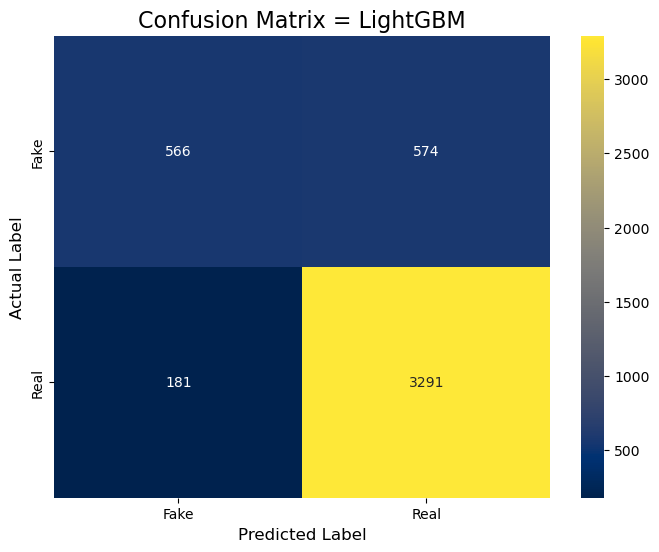

In [24]:
# defining all models
# (model name, model, hyper-parameters) 
models = [("Logistic Regression", 
           LogisticRegression(max_iter=1000, random_state=42),
           {"classifier__C" : uniform(0.1,10),
            "classifier__solver": ["liblinear", "saga"]
           }
          ),
          ("Multinomial Naive Bayes",
           MultinomialNB(),
           {"classifier__alpha": uniform(0.01, 1.0)}
          ),
          ("Linear SVM",
           LinearSVC(max_iter=2000, random_state=42),
           {"classifier__C": uniform(0.1,10)}
          ),
          ("Random Forest",
           RandomForestClassifier(random_state=42),
           {"classifier__n_estimators": randint(100,500),
            "classifier__max_depth": [5, 10, 20, 30],
            "classifier__min_samples_leaf":randint(1,5)
           }
          ),
          ("LightGBM",
           LGBMClassifier(random_state=42),
           {"classifier__n_estimators": randint(100,500),
            "classifier__learning_rate": uniform(0.01,0.2),
            "classifier__num_leaves": randint(20,50)
           }
          )]

results = {}

for name, classifier, params in models:
    print(f"\n--- Training and Tuning {name} ---")
    pipeline = Pipeline([("vectorizer", TfidfVectorizer(stop_words="english")), 
                         ("classifier", classifier)
                        ])
    random_search = RandomizedSearchCV(pipeline, 
                                       param_distributions=params,
                                       n_iter=20,
                                       cv=3,
                                       verbose=1,
                                       random_state=42,
                                       n_jobs=-1
                                      )
    random_search.fit(X_train, y_train)
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)

    if hasattr(best_model.named_steps["classifier"], "predict_proba"):
        y_proba = best_model.predict_proba(X_test)[:,1]
    else:
        y_proba = best_model.decision_function(X_test)

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"Accuracy": acc, "ROC AUC": auc}

    print(f"\nBest parameters for {name}: ")
    print(random_search.best_params_)
    print(f"\nAccuracy for {name}: {acc:.4f}")
    print(f"\nROC AUC for {name}: {auc:.4f}")
    print(f"\nClassification Report: ")
    print(classification_report(y_test, y_pred, target_names=["Fake", "Real"]))

    plot_confusion_matrix(y_test, y_pred, name)

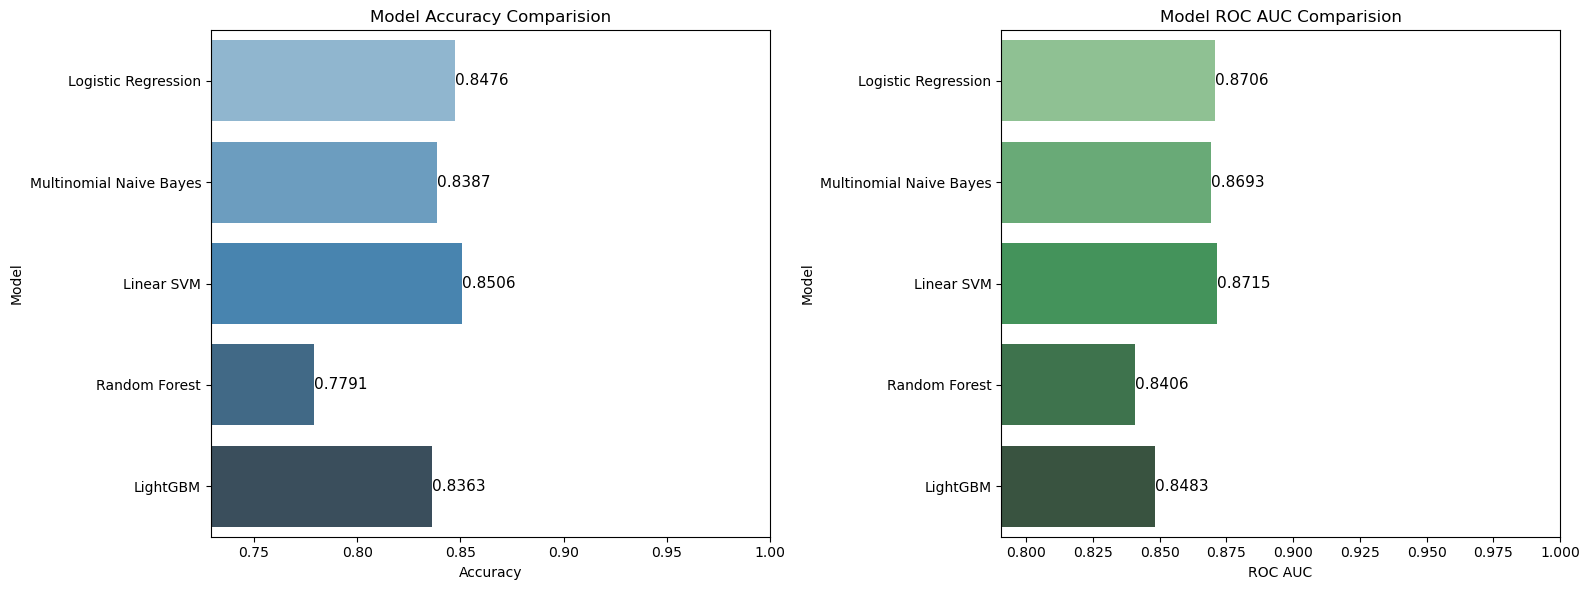

In [25]:
results_df = pd.DataFrame(results).T.reset_index().rename(columns={"index": "Model"})

fig, ax = plt.subplots(1,2,figsize=(16,6))

sns.barplot(x="Accuracy", y="Model", data=results_df, ax=ax[0], hue="Model", palette="Blues_d", legend=False)
ax[0].set_title("Model Accuracy Comparision")
ax[0].set_xlim(results_df["Accuracy"].min() - 0.05, 1.0)

sns.barplot(x="ROC AUC", y="Model", data=results_df, ax=ax[1], hue="Model", palette="Greens_d", legend=False)
ax[1].set_title("Model ROC AUC Comparision")
ax[1].set_xlim(results_df["ROC AUC"].min() - 0.05, 1.0)

for i, row in results_df.iterrows():
    ax[0].text(row["Accuracy"], i, f"{row["Accuracy"]:.4f}", va="center", fontsize=11)
    ax[1].text(row["ROC AUC"], i, f"{row["ROC AUC"]:.4f}", va="center", fontsize=11)

plt.tight_layout()
plt.show()